In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from arch import arch_model
import seaborn as sns

In [6]:
import arch
print("arch version:", arch.__version__)

arch version: 7.2.0


[*********************100%***********************]  1 of 1 completed
/var/folders/yq/6h47_f4s3g16nl2gbhk2pvv80000gn/T/ipykernel_22270/1299916641.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_data.rename(columns={'Close': 'Gold_Price'}, inplace=True)


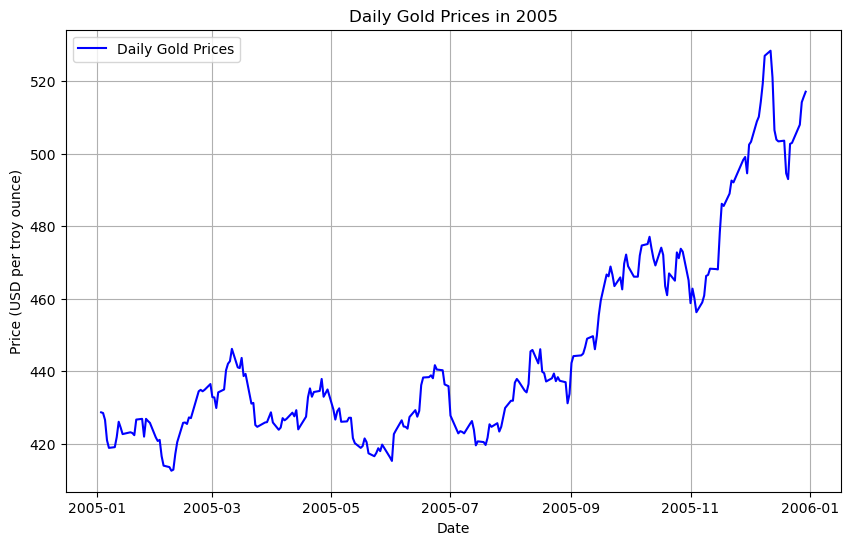

In [8]:
# Download Gold data using yfinance
gold_data = yf.download("GC=F", start="2005-01-01", end="2005-12-31")
gold_data.reset_index(inplace=True)
gold_data = gold_data[['Date', 'Close']]  # Extract only the closing price
gold_data.rename(columns={'Close': 'Gold_Price'}, inplace=True)

# Create a time series plot
plt.figure(figsize=(10, 6))
plt.plot(gold_data['Date'], gold_data['Gold_Price'], label='Daily Gold Prices', color='blue')
plt.title("Daily Gold Prices in 2005")
plt.xlabel("Date")
plt.ylabel("Price (USD per troy ounce)")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Augmented Dickey-Fuller Test for stationarity
adf_test = adfuller(gold_data['Gold_Price'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
if adf_test[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary.")

ADF Statistic: 0.21700673428391498
p-value: 0.9731994802170015
The series is non-stationary.


/var/folders/yq/6h47_f4s3g16nl2gbhk2pvv80000gn/T/ipykernel_22270/315054589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_data['Diff_Gold_Price'] = gold_data['Gold_Price'].diff()


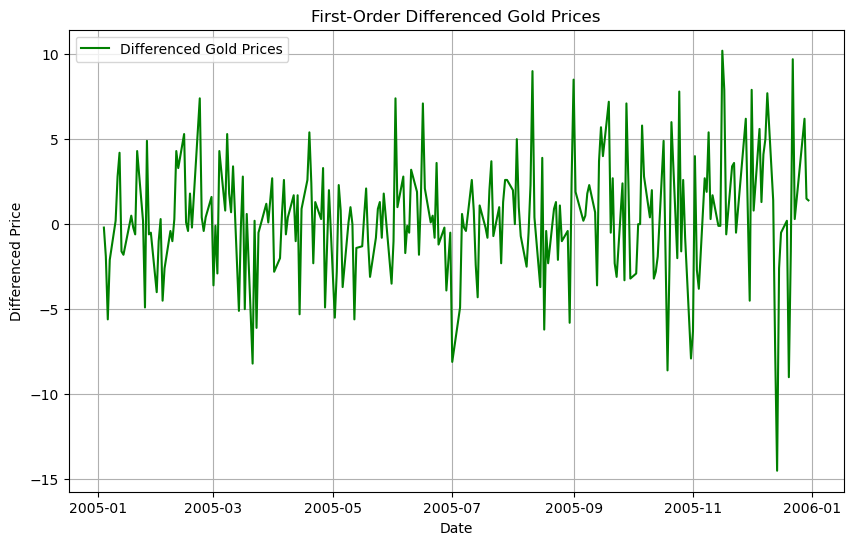

<Figure size 1200x600 with 0 Axes>

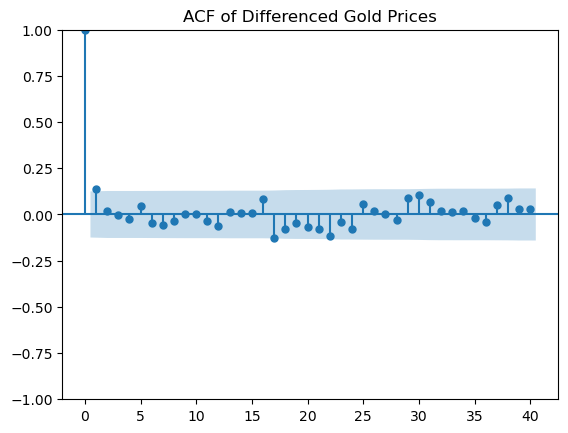

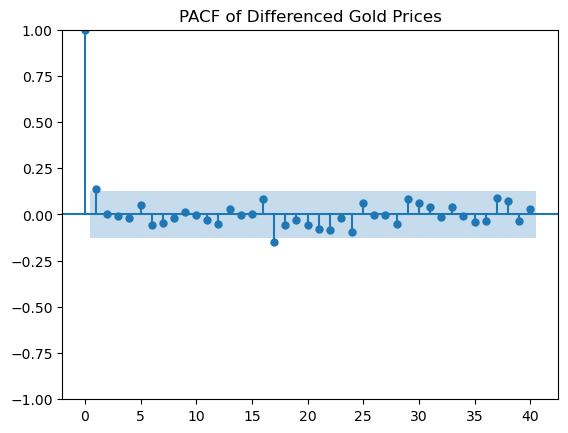

In [11]:
# Apply first-order differencing
gold_data['Diff_Gold_Price'] = gold_data['Gold_Price'].diff()

# Drop NaN values after differencing
gold_data_diff = gold_data.dropna(subset=['Diff_Gold_Price'])

# Plot the differenced series
plt.figure(figsize=(10, 6))
plt.plot(gold_data_diff['Date'], gold_data_diff['Diff_Gold_Price'], label='Differenced Gold Prices', color='green')
plt.title("First-Order Differenced Gold Prices")
plt.xlabel("Date")
plt.ylabel("Differenced Price")
plt.legend()
plt.grid(True)
plt.show()

# ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(gold_data_diff['Diff_Gold_Price'], lags=40, title="ACF of Differenced Gold Prices")
plot_pacf(gold_data_diff['Diff_Gold_Price'], lags=40, title="PACF of Differenced Gold Prices")
plt.show()

                               SARIMAX Results                                
Dep. Variable:             Gold_Price   No. Observations:                  248
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -665.894
Date:                Sat, 30 Nov 2024   AIC                           1333.788
Time:                        17:53:57   BIC                           1337.297
Sample:                             0   HQIC                          1335.201
                                - 248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        12.8581      0.930     13.821      0.000      11.035      14.682
Ljung-Box (L1) (Q):                   4.82   Jarque-Bera (JB):                16.08
Prob(Q):                              0.03   Pr

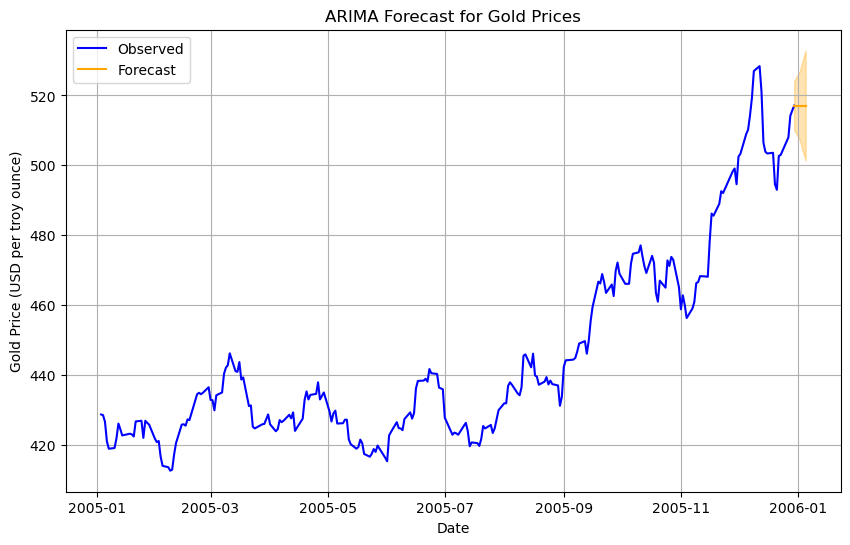

In [13]:
# Fit ARIMA model
model = ARIMA(gold_data['Gold_Price'], order=(0, 1, 0))  # Example ARIMA(0,1,0)
fit_arima = model.fit()

# Print model summary
print(fit_arima.summary())

# Forecast next 5 days
forecast = fit_arima.get_forecast(steps=5)
forecast_summary = forecast.summary_frame()
print(forecast_summary)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(gold_data['Date'], gold_data['Gold_Price'], label='Observed', color='blue')
plt.plot(pd.date_range(start=gold_data['Date'].iloc[-1], periods=5, freq='B'), 
         forecast_summary['mean'], label='Forecast', color='orange')
plt.fill_between(pd.date_range(start=gold_data['Date'].iloc[-1], periods=5, freq='B'),
                 forecast_summary['mean_ci_lower'], forecast_summary['mean_ci_upper'], color='orange', alpha=0.3)
plt.title("ARIMA Forecast for Gold Prices")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD per troy ounce)")
plt.legend()
plt.grid(True)
plt.show()

                     Constant Mean - GARCH Model Results                      
Dep. Variable:        Diff_Gold_Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -656.864
Distribution:                  Normal   AIC:                           1321.73
Method:            Maximum Likelihood   BIC:                           1335.76
                                        No. Observations:                  247
Date:                Sat, Nov 30 2024   Df Residuals:                      246
Time:                        17:54:08   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2335      0.222      1.051      0.293 [ -0.202,  0.66

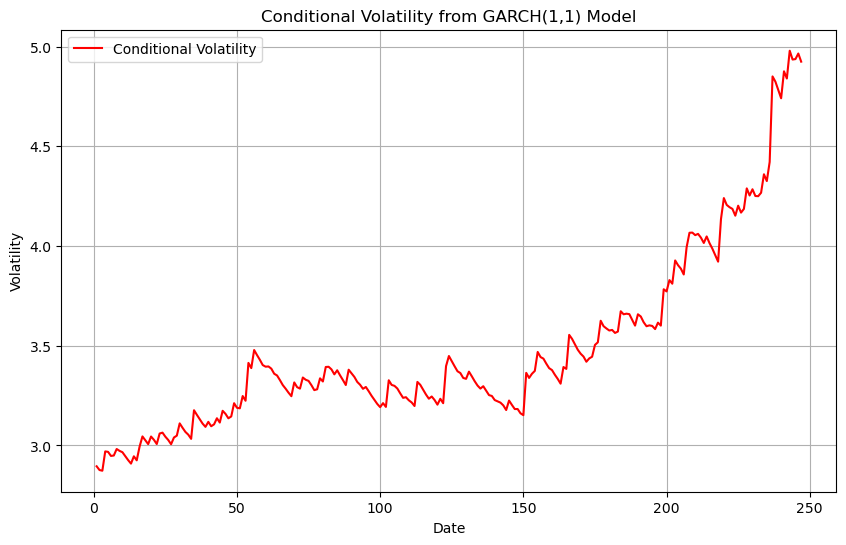

In [14]:
# Fit GARCH(1,1) model on the differenced series
garch_model = arch_model(gold_data['Diff_Gold_Price'].dropna(), vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")
print(garch_fit.summary())

# Plot conditional volatility
plt.figure(figsize=(10, 6))
plt.plot(garch_fit.conditional_volatility, label='Conditional Volatility', color='red')
plt.title("Conditional Volatility from GARCH(1,1) Model")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

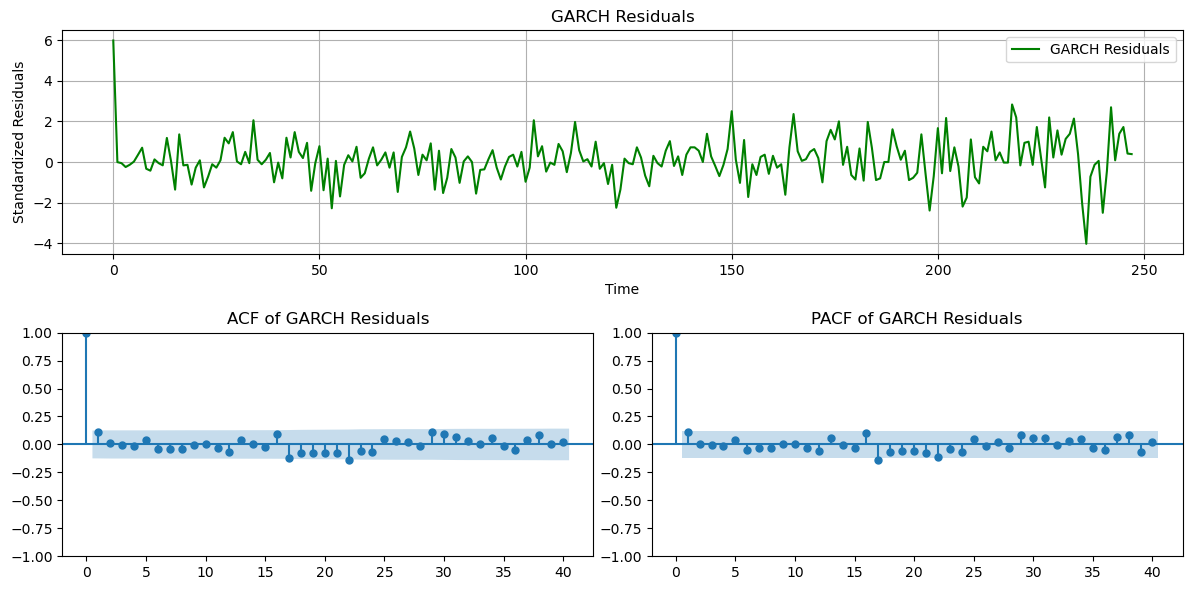

In [21]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract GARCH residuals
garch_residuals = garch_fit.resid / garch_fit.conditional_volatility

# Plot GARCH residuals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(garch_residuals, label='GARCH Residuals', color='green')
plt.title("GARCH Residuals")
plt.xlabel("Time")
plt.ylabel("Standardized Residuals")
plt.legend()
plt.grid(True)

# Plot ACF of GARCH residuals
plt.subplot(2, 2, 3)
plot_acf(garch_residuals, lags=40, ax=plt.gca(), title="ACF of GARCH Residuals")

# Plot PACF of GARCH residuals
plt.subplot(2, 2, 4)
plot_pacf(garch_residuals, lags=40, ax=plt.gca(), title="PACF of GARCH Residuals")

plt.tight_layout()
plt.show()


In [1]:
from anytree import Node, RenderTree
from anytree.exporter import DotExporter

# Define the tree
root = Node("Dataset (Nov. 2019 – Oct. 2024)")
split = Node("Train-Test Split: Forward Cross-Validation", parent=root)

# Regression Models
regression = Node("Regression Models", parent=split)
Node("LSTM", parent=regression)
Node("Linear Regression", parent=regression)
Node("XGBoost", parent=regression)
Node("SVR (Support Vector Regression)", parent=regression)
Node("VAR (Vector AutoRegression)", parent=regression)
Node("Backtesting: Performance Evaluation", parent=regression)

# Classification Models
classification = Node("Classification Models", parent=split)
Node("KNN (K-Nearest Neighbors)", parent=classification)
Node("SVM (Support Vector Machine)", parent=classification)
Node("Random Forest", parent=classification)
Node("Logistic Regression", parent=classification)
Node("Backtesting: Performance Evaluation", parent=classification)

# Render the tree
for pre, _, node in RenderTree(root):
    print(f"{pre}{node.name}")

# Export tree to a file
DotExporter(root).to_picture("workflow_tree.png")


Dataset (Nov. 2019 – Oct. 2024)
└── Train-Test Split: Forward Cross-Validation
    ├── Regression Models
    │   ├── LSTM
    │   ├── Linear Regression
    │   ├── XGBoost
    │   ├── SVR (Support Vector Regression)
    │   ├── VAR (Vector AutoRegression)
    │   └── Backtesting: Performance Evaluation
    └── Classification Models
        ├── KNN (K-Nearest Neighbors)
        ├── SVM (Support Vector Machine)
        ├── Random Forest
        ├── Logistic Regression
        └── Backtesting: Performance Evaluation


FileNotFoundError: [Errno 2] No such file or directory: 'dot'

In [3]:
from graphviz import Digraph

# Initialize the tree
dot = Digraph(format="png")
dot.attr(rankdir="TB", size="8,10")  # Top-to-Bottom layout

# Root Node
dot.node("Dataset", "Dataset\n(Nov. 2019 – Oct. 2024)")

# Train-Test Split
dot.node("Split", "Train-Test Split:\nForward Cross-Validation")
dot.edge("Dataset", "Split")

# Regression Models
dot.node("Regression", "Regression Models")
dot.edge("Split", "Regression")

# Regression Submodels
regression_models = ["LSTM", "Linear Regression", "XGBoost", "SVR (Support Vector Regression)", "VAR (Vector AutoRegression)"]
for model in regression_models:
    dot.node(model, model)
    dot.edge("Regression", model)

# Backtesting: Regression
dot.node("Backtest_R", "Backtesting:\nPerformance Evaluation")
dot.edge("Regression", "Backtest_R")

# Metrics and Visualizations (Regression)
dot.node("Metrics_R", "Metrics:\nMSE, RMSE, MAE")
dot.node("Viz_R", "Visualization:\nLine Plots, Scatterplots")
dot.edge("Backtest_R", "Metrics_R")
dot.edge("Backtest_R", "Viz_R")

# Classification Models
dot.node("Classification", "Classification Models")
dot.edge("Split", "Classification")

# Classification Submodels
classification_models = ["KNN (K-Nearest Neighbors)", "SVM (Support Vector Machine)", "Random Forest", "Logistic Regression"]
for model in classification_models:
    dot.node(model, model)
    dot.edge("Classification", model)

# Backtesting: Classification
dot.node("Backtest_C", "Backtesting:\nPerformance Evaluation")
dot.edge("Classification", "Backtest_C")

# Metrics and Visualizations (Classification)
dot.node("Metrics_C", "Metrics:\nAccuracy, Precision, Recall, F1 Score")
dot.node("Viz_C", "Visualization:\nConfusion Matrix, ROC Curves")
dot.edge("Backtest_C", "Metrics_C")
dot.edge("Backtest_C", "Viz_C")

# Render the tree diagram
dot.render("workflow_tree", view=True)


'workflow_tree.png'